<h1>3rd Try </h1>

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif , chi2

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import imblearn

from imblearn.over_sampling import SMOTE

import xgboost as xgb

from sklearn import tree

from sklearn.ensemble import GradientBoostingClassifier

In [67]:
# ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [68]:
df_features = pd.read_csv('data/train_values.csv',index_col='building_id')
df_target = pd.read_csv('data/train_labels.csv',index_col='building_id')

df_test= pd.read_csv('data/test_values.csv',index_col='building_id')

In [69]:
print(df_features.shape)
print(df_target.shape)

(260601, 38)
(260601, 1)


In [70]:
num_features= df_features.select_dtypes(np.number)

obj_features= df_features.select_dtypes('object')



<h3>Remover variables constantes</h3>

In [71]:
# using sklearn variancethreshold to find constant features

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(num_features)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [72]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

30

<h5> Todas las variables numéricas no son constantes </h5>

<h3>Remover variables que tienen poca variabilidad</h3>

In [73]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(num_features)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [74]:
# get_support is a boolean vector that indicates which features 
# are retained. If we sum over get_support, we get the number
# of features that are not quasi-constant
sum(sel.get_support())

22

In [75]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in num_features.columns
        if x not in num_features.columns[sel.get_support()]
    ]))

[x for x in num_features.columns if x not in num_features.columns[sel.get_support()]]

8


['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

We can see that 8 columns / variables are almost constant. This means that 8 variables show predominantly one value for ~99% the observations of the training set.

In [76]:
#ejemplo de la variabilidad de las categorias dentro de un feature/variable

df_features['has_secondary_use_rental'].value_counts()/len(df_features)

0    0.991899
1    0.008101
Name: has_secondary_use_rental, dtype: float64

In [77]:
#removemos los features tanto del train como del test

df_features.drop(['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other'],axis=1,inplace=True)



In [78]:
df_test.drop(['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other'],axis=1,inplace=True)

In [79]:
print(df_features.shape)
print(df_test.shape)

(260601, 30)
(86868, 30)


In [80]:
df_features.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000


In [81]:
df_features['age'].describe()

count    260601.000000
mean         26.535029
std          73.565937
min           0.000000
25%          10.000000
50%          15.000000
75%          30.000000
max         995.000000
Name: age, dtype: float64

In [82]:
#Age column has a value 995, we are going to drop it

#df_features.drop(df_features[df_features['age'].isin([200,195,200,995])].index,inplace=True)



In [83]:
df_features.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000


In [84]:
df=df_features.join(df_target)

In [85]:
df.shape

(260601, 31)

In [86]:
len(df[df['age']>120])

1734

In [87]:
df = df[df['age']<=120]

In [88]:
df.shape

(258867, 31)

<AxesSubplot: xlabel='age', ylabel='count'>

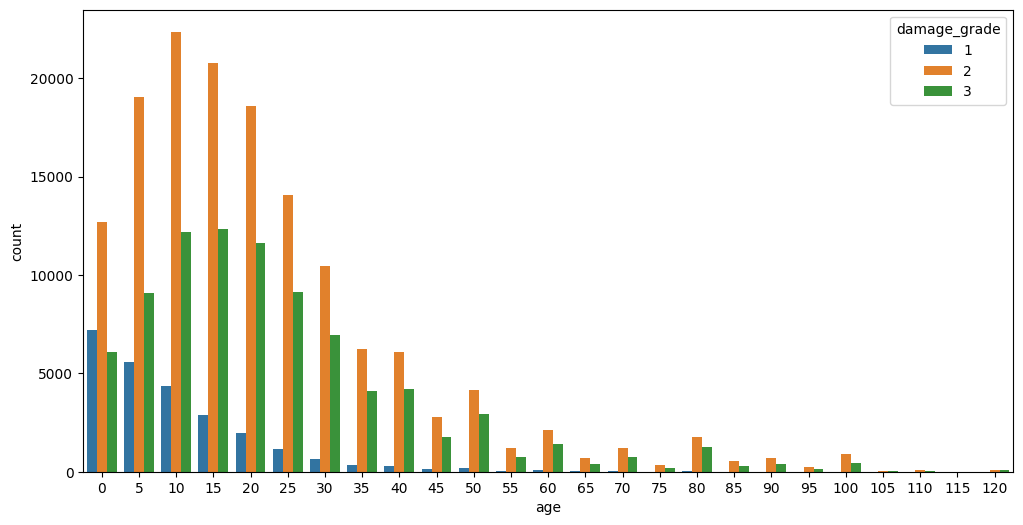

In [89]:
plt.rcParams['figure.figsize']=12,6

sns.countplot(data=df,x='age',hue='damage_grade')

<h3>Categorical feature selection</h3>

In [90]:
df.select_dtypes('object').columns

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

In [91]:
categorical_columns=df.select_dtypes('object')

object_cols = df.select_dtypes('object').columns


<AxesSubplot: xlabel='legal_ownership_status', ylabel='count'>

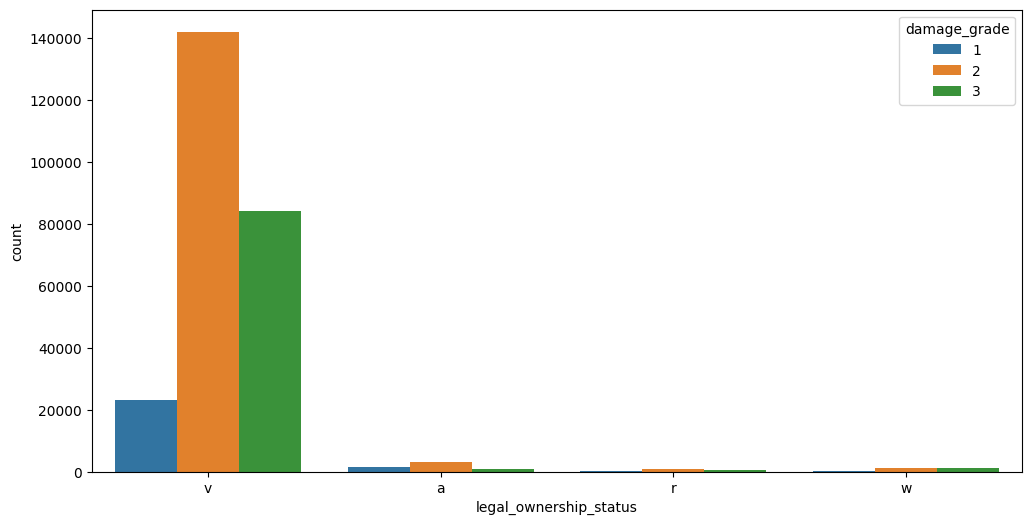

In [92]:
sns.countplot(data=df,x='legal_ownership_status',hue='damage_grade')

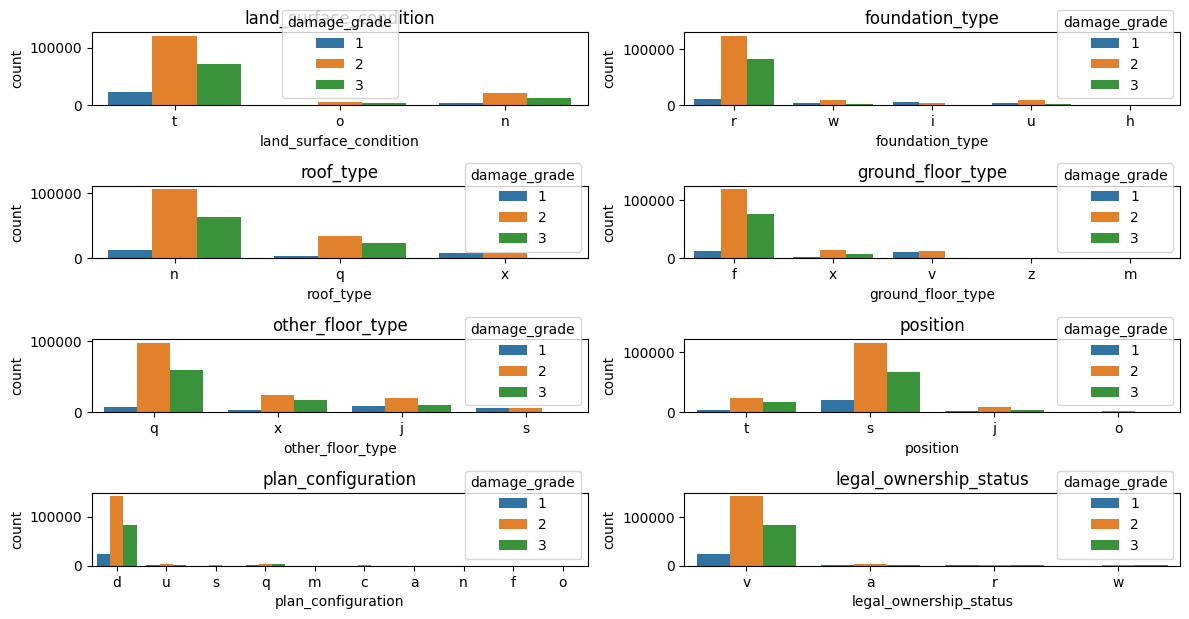

In [93]:
fig = plt.figure(figsize=(12,12))
for i, col in enumerate(object_cols):
    plt.subplot(len(object_cols), 2, i+1)
    
    ax=sns.countplot(x=col,hue='damage_grade', data=df)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [94]:
df.groupby(['land_surface_condition','damage_grade'])['damage_grade'].count()

land_surface_condition  damage_grade
n                       1                 2538
                        2                21385
                        3                11444
o                       1                  601
                        2                 4695
                        3                 3000
t                       1                21801
                        2               121130
                        3                72273
Name: damage_grade, dtype: int64

In [95]:
df.drop([ 'foundation_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],axis=1,inplace=True)

df_test.drop([ 'foundation_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],axis=1,inplace=True)

In [96]:
df.shape

(258867, 25)

In [97]:
df=pd.get_dummies(df)
df_test=pd.get_dummies(df_test)

In [98]:
df.shape

(258867, 29)

In [99]:
df.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'damage_grade', 'land_surface_condition_n',
       'land_surface_condition_o', 'land_surface_condition_t', 'roof_type_n',
       'roof_type_q', 'roof_type_x'],
      dtype='object')

In [100]:
df['damage_grade']

building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 258867, dtype: int64

In [101]:
df.corrwith(df['damage_grade'])

geo_level_1_id                           -0.072424
geo_level_2_id                            0.042910
geo_level_3_id                            0.007834
count_floors_pre_eq                       0.123385
age                                       0.152949
area_percentage                          -0.125080
height_percentage                         0.048613
has_superstructure_adobe_mud              0.055952
has_superstructure_mud_mortar_stone       0.292142
has_superstructure_stone_flag             0.066543
has_superstructure_cement_mortar_stone   -0.060596
has_superstructure_mud_mortar_brick       0.014813
has_superstructure_cement_mortar_brick   -0.254680
has_superstructure_timber                -0.069097
has_superstructure_bamboo                -0.062345
has_superstructure_rc_non_engineered     -0.158470
has_superstructure_rc_engineered         -0.179367
has_superstructure_other                 -0.029934
count_families                            0.056040
has_secondary_use              

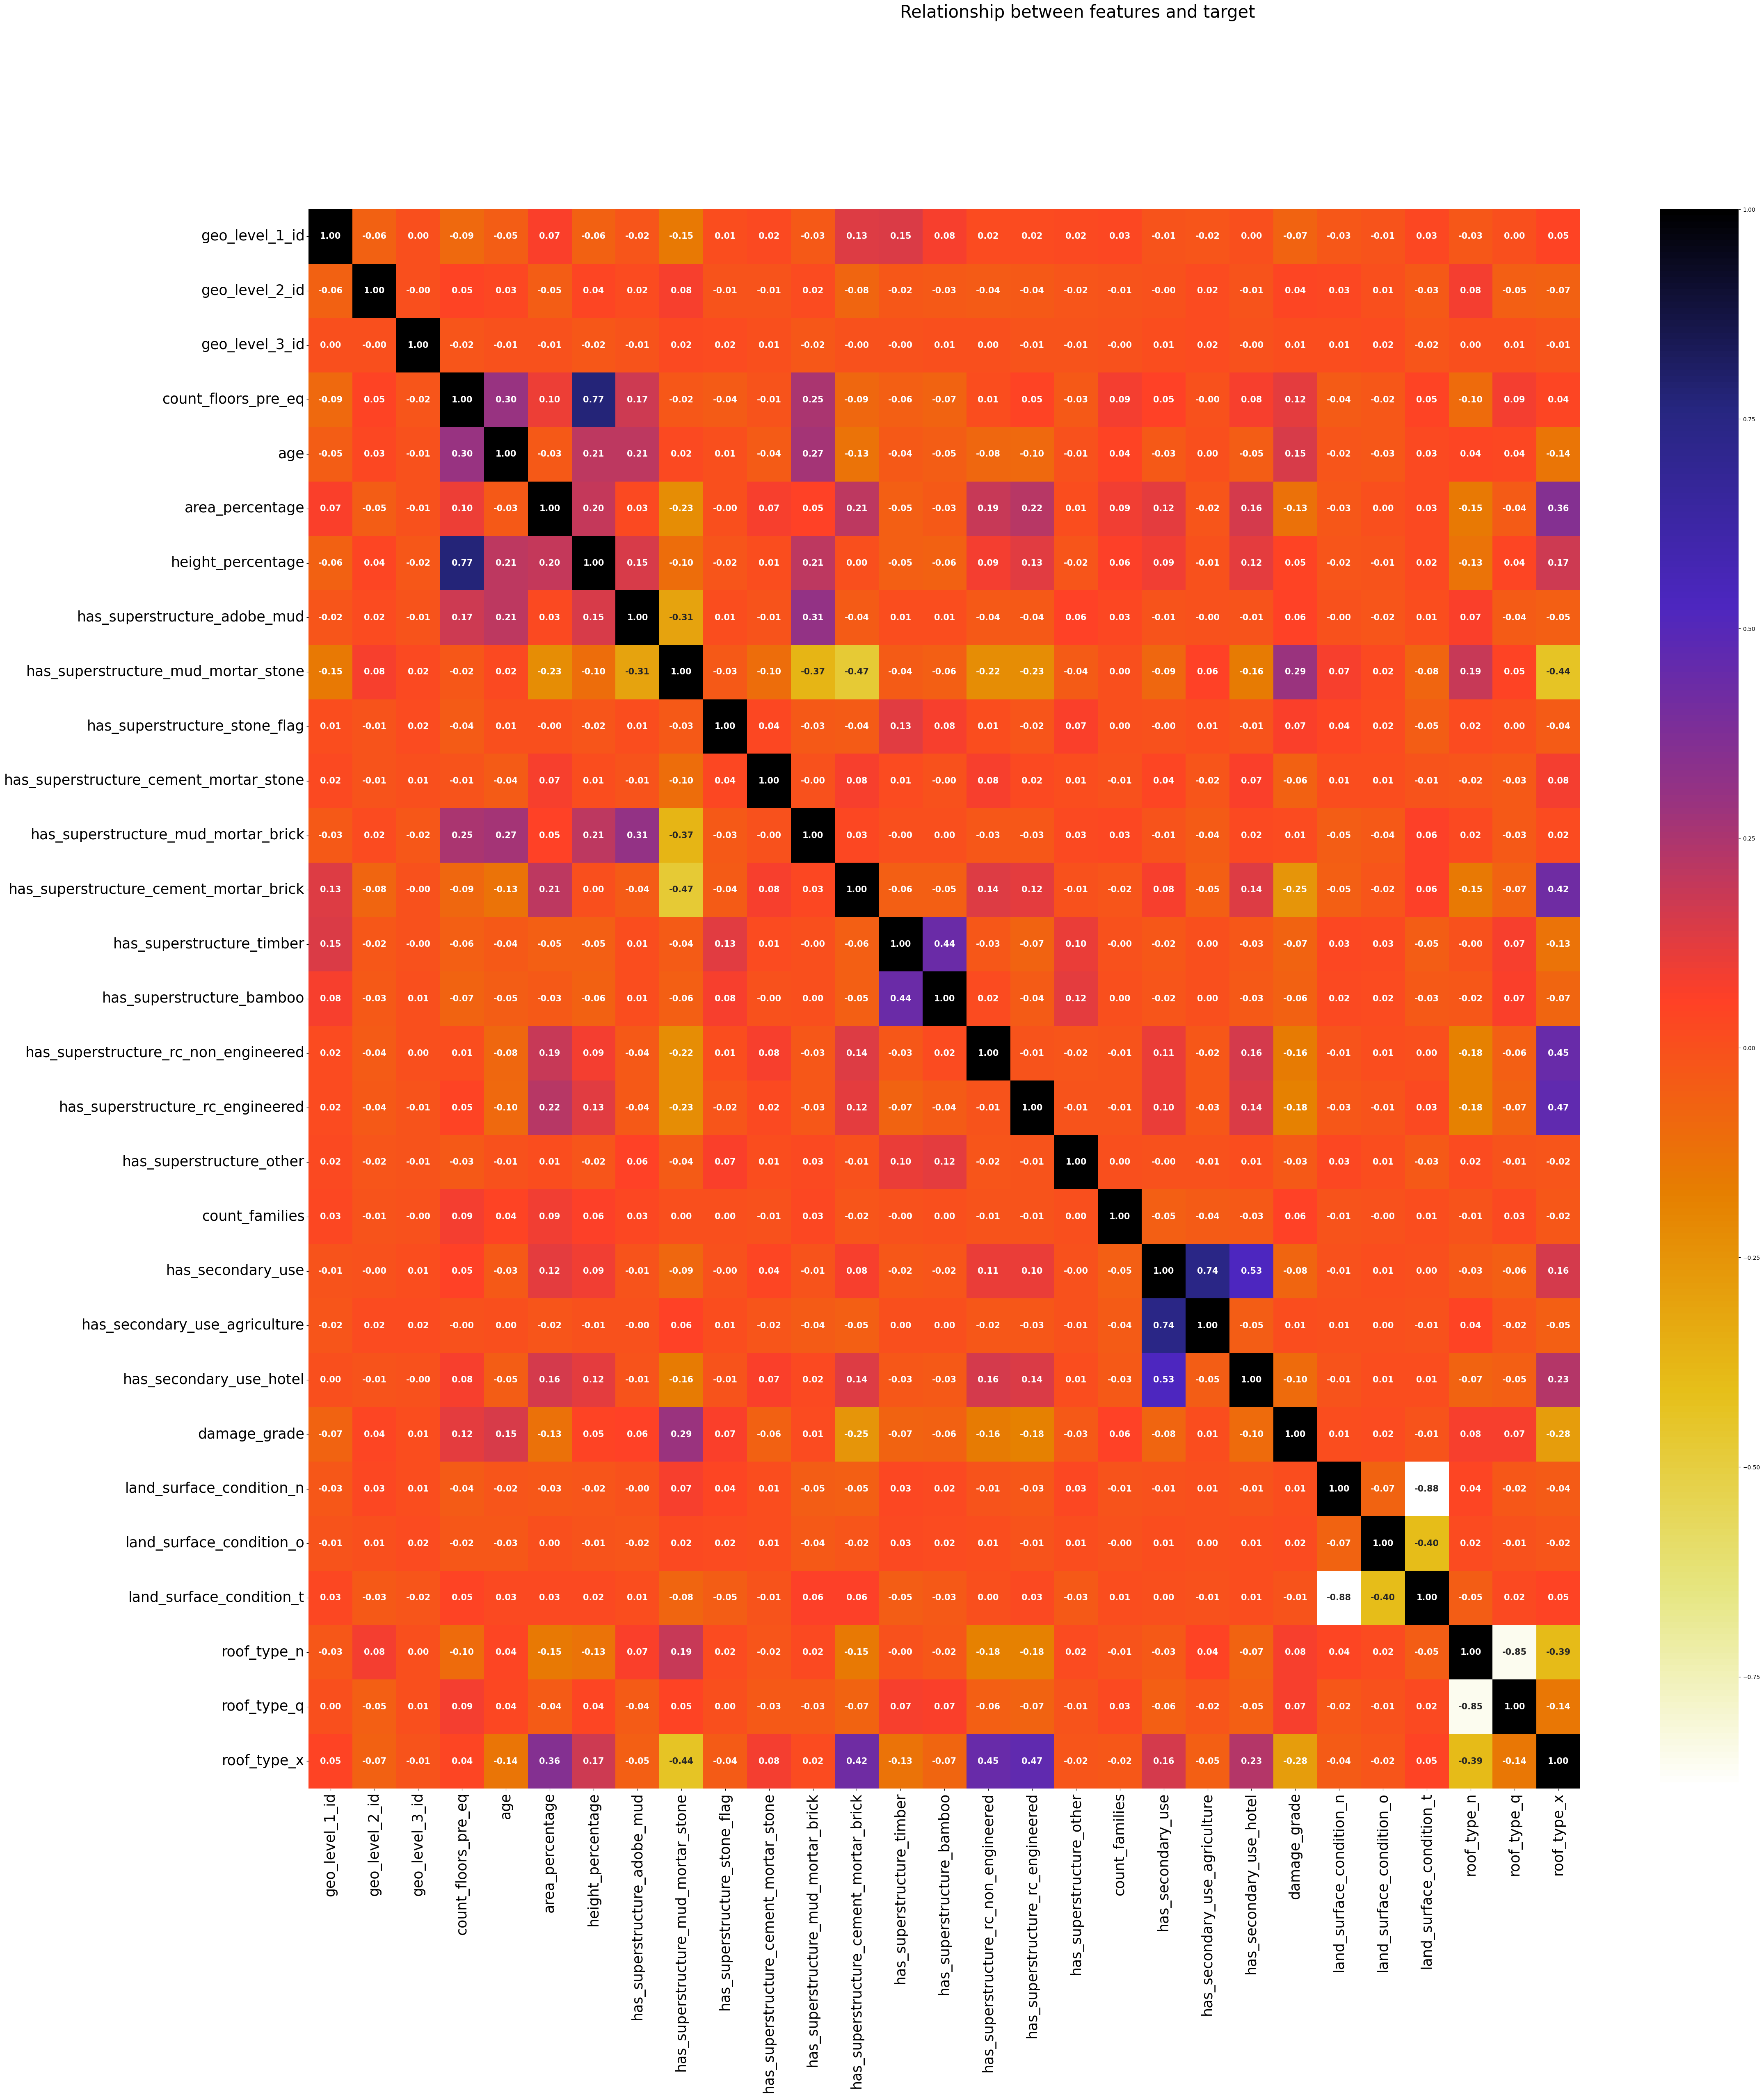

In [102]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(df.corr(),annot=True,annot_kws={'size': 15,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()


In [103]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [104]:
corr_features=correlation(df,0.7)
len(set(corr_features))

4

In [105]:
corr_features

{'has_secondary_use_agriculture',
 'height_percentage',
 'land_surface_condition_t',
 'roof_type_q'}

In [106]:
df.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

In [107]:
df.shape

(258867, 25)

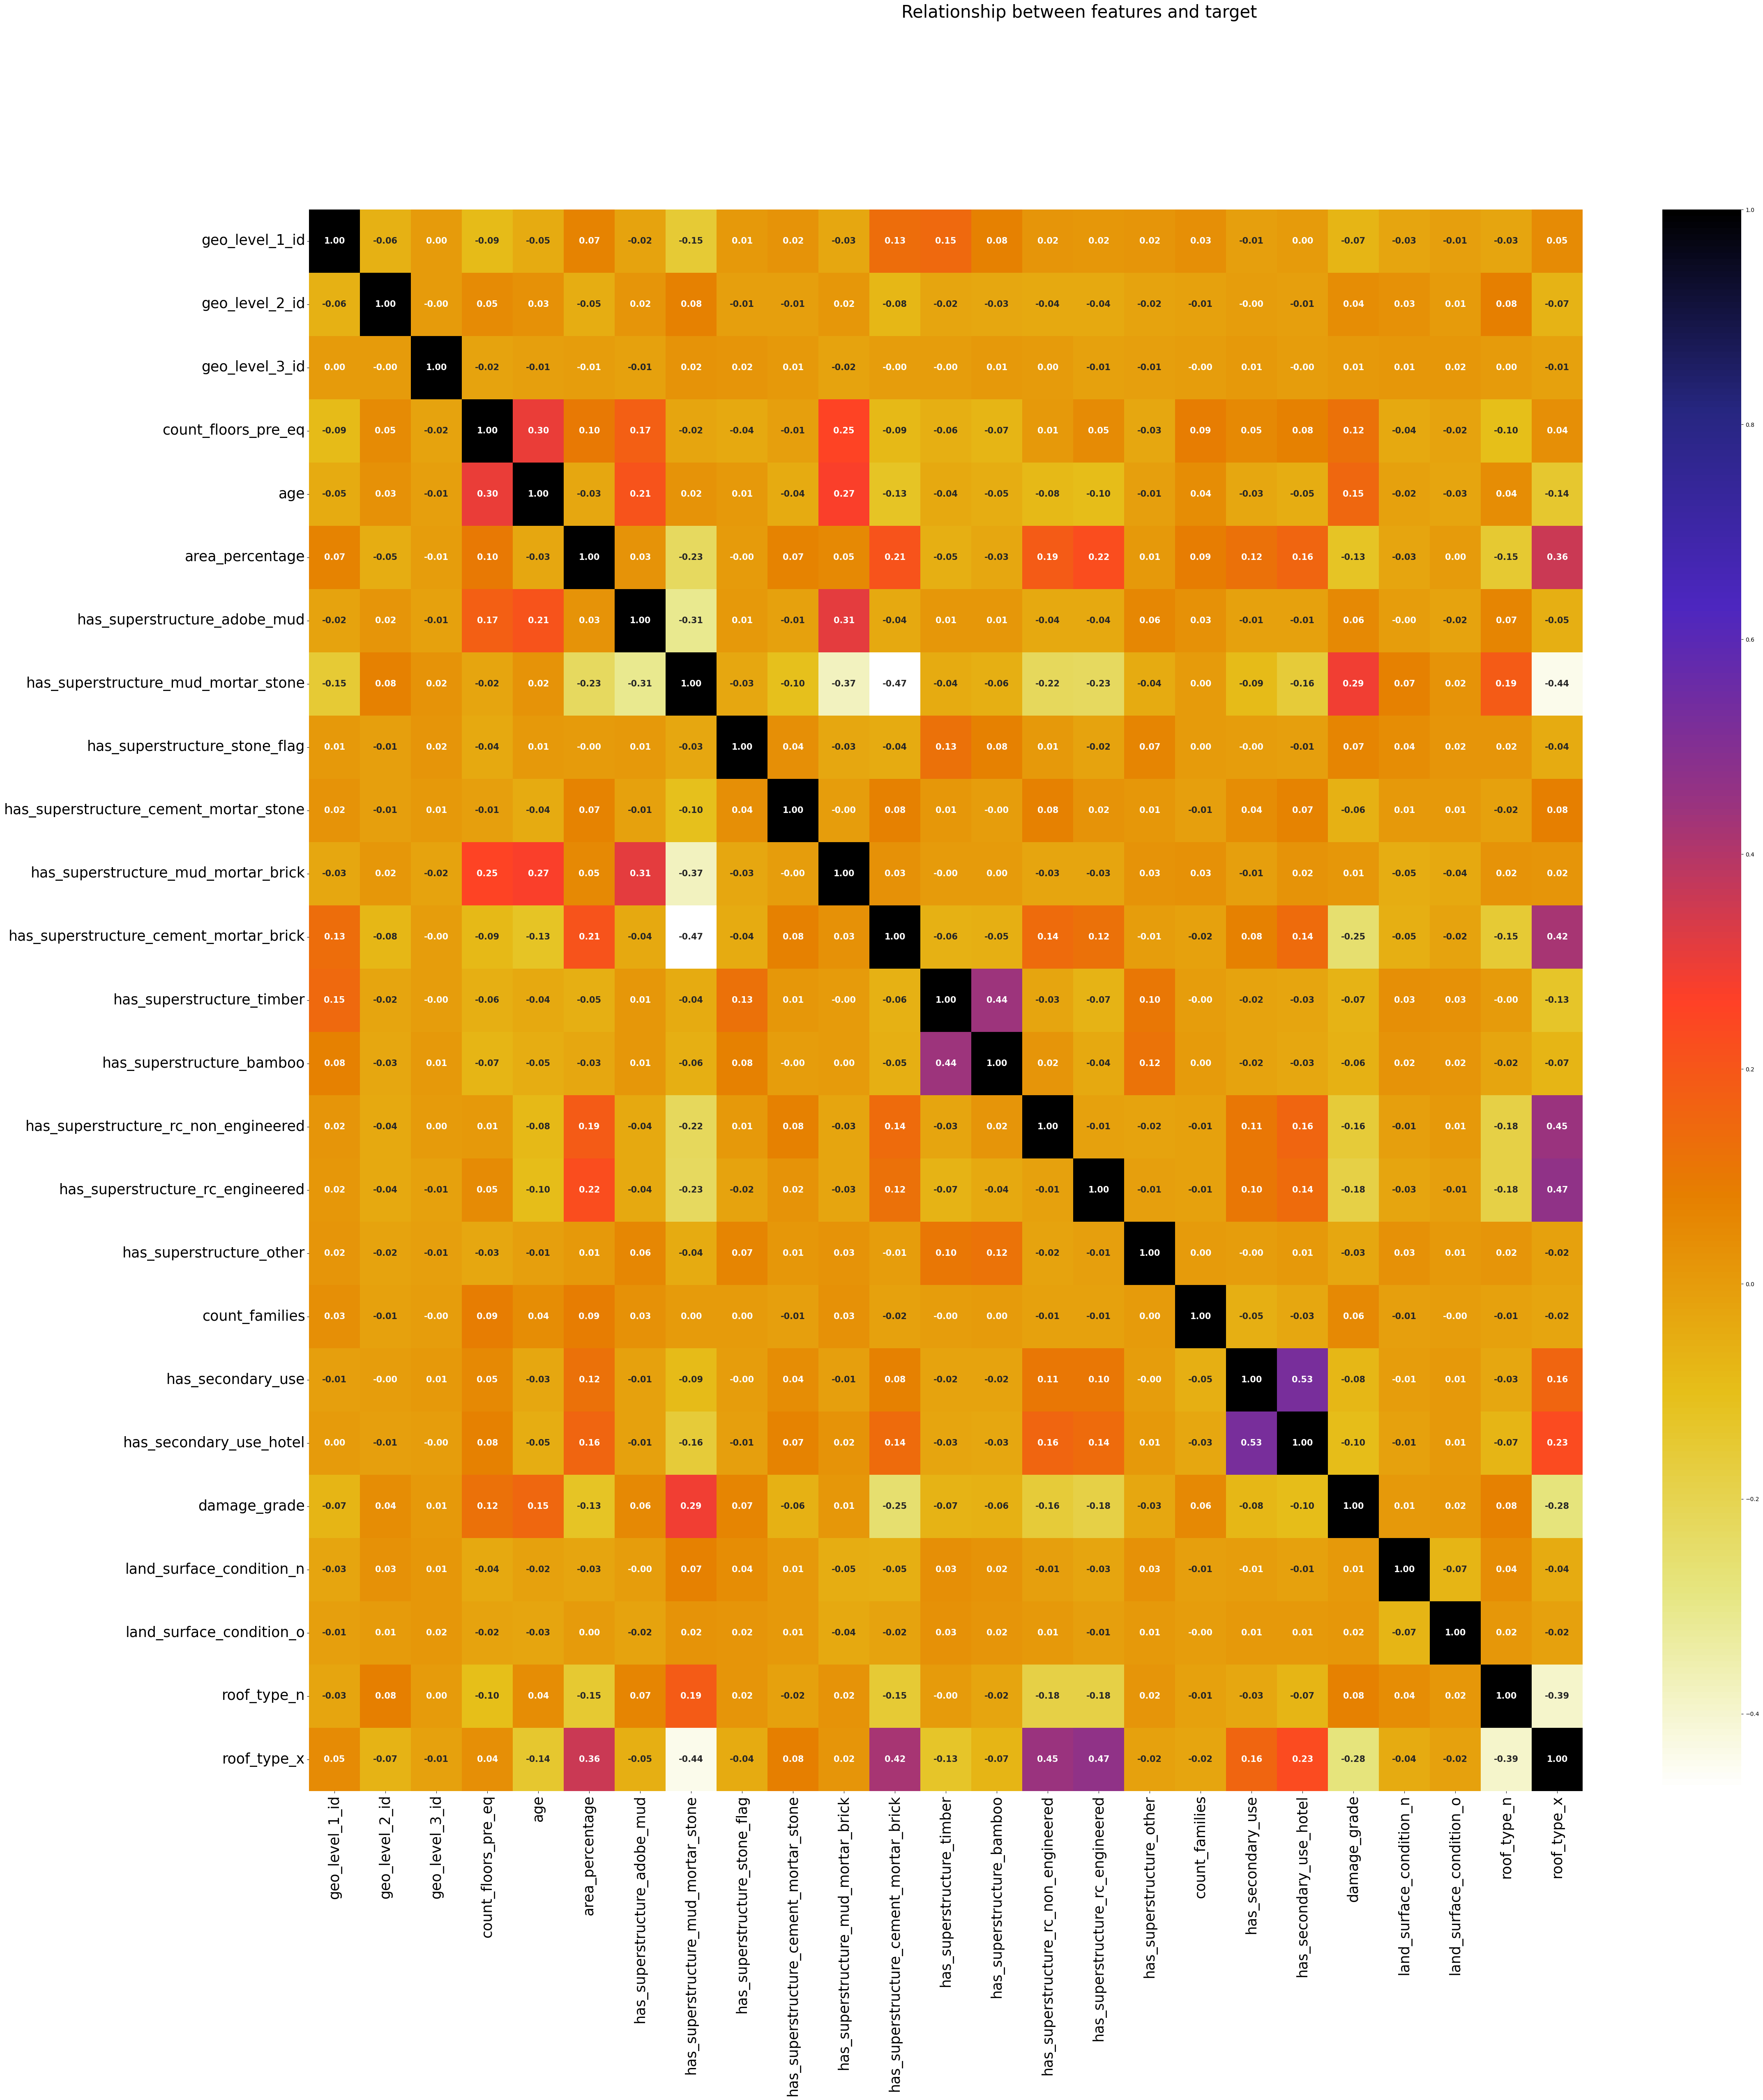

In [108]:
fig, ax= plt.subplots(figsize=(50,50))
sns.heatmap(df.corr(),annot=True,annot_kws={'size': 15,'weight': 'bold'},cmap='CMRmap_r',fmt=".2f")
plt.suptitle("Relationship between features and target",size=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()

In [109]:
oversample = SMOTE()

X = df.drop(['damage_grade'],axis=1)
y = df['damage_grade']

num_cols =X.select_dtypes(np.number).columns



In [110]:
#num_cols =X.select_dtypes(np.number).columns

#Standard Scaler and transform

#num_transformer = StandardScaler()


#X[num_cols]=num_transformer.fit_transform(X[num_cols])
#df_test[num_cols]=num_transformer.fit_transform(df_test[num_cols])






In [111]:
X, y = oversample.fit_resample(X, y)

In [112]:
X.shape

(441630, 24)

In [113]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.25,random_state=42)

In [114]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train,y_train)

predictions = clf.predict(X_test)

f1_score_pred = f1_score(y_test,predictions,average='micro')

print('f1_score_predictions: ',f1_score_pred)

f1_score_predictions:  0.7633323672197667


In [128]:
clf2 = GradientBoostingClassifier(n_estimators=100,min_samples_split=200, learning_rate=0.4, max_depth=7, random_state=42).fit(X_train, y_train)

predictions2 = clf2.predict(X_test)

f1_score_pred2 = f1_score(y_test,predictions2,average='micro')

print('f1_score_predictions: ',f1_score_pred2)

f1_score_predictions:  0.7985743786682125


In [129]:
predictions2b = clf2.predict(X_train)

f1_score_pred2b = f1_score(y_train,predictions2b,average='micro')

print('f1_score_predictions: ',f1_score_pred2b)

f1_score_predictions:  0.8217087029243226


In [130]:
predictions = clf2.predict(df_test)

In [131]:
submission_format = pd.read_csv('data/submission_format.csv', index_col='building_id')

In [132]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [133]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [134]:
my_submission.to_csv('submission3.csv')